In [1]:
import numpy as np
import pandas as pd
import pydot
import sys
from sklearn.datasets import load_diabetes
from IPython.display import Image, display

In [2]:
class Node(object):
    def __init__(self):
        self.value = None              # feature name for binary split the current node / class label at leaf node
        self.pathCondition = None      # threshold for binary split i.e. value <= pathCondition
        
        self.leftChild = None          # tree path if condition is met
        self.rightChild = None         # tree path if condition is not met
        
        self.variance = None           # variance of the node
        self.samples = None            # number of samples in node

In [3]:
def getVarianceOfNode(target_column):
    
    # Total number of samples in target column T
    msamples = target_column.shape[0]
    
    mu = np.mean(target_column.values)
    
    target_column = target_column.copy()
    
    variance = np.sum(((target_column - mu)**2)/msamples)
    
    return variance, mu

In [4]:
def compute_required_min_impurity_decrease(df, cthreshold, F):
    
    group1 = df[df[F] <= cthreshold]
    group2 = df[df[F] > cthreshold]
    
    T = df.shape[0]
    T1 = group1.shape[0]
    T2 = group2.shape[0]   
    
    variance_before, leaf_label = getVarianceOfNode(df[target])
    variance_group1, leaf_label1 = getVarianceOfNode(group1[target])
    variance_group2, leaf_label2 = getVarianceOfNode(group2[target])
    
    min_impurity_decrease = (T / m) * (variance_before - (T2 / T) * variance_group2
                                - (T1 / T) * variance_group1)
    
    return min_impurity_decrease

In [5]:
def get_reduction_in_variance(variance_before, variance_after):
    
    reduction_in_variance = variance_before - variance_after
    
    return reduction_in_variance

In [6]:
def findBestSplit(df, features):
    
    maxReduction_in_variance = 0
    lowestVariance_after = sys.maxsize
    cthreshold = None
    tthreshold = None
    F = -1
    
    variance_before, leaf_label = getVarianceOfNode(df[target])
    
    if variance_before == 0:
        return maxReduction_in_variance, F, cthreshold, leaf_label
    
    T = df.shape[0]
    
    for f in features:

        values = df[f].values
        values = np.sort(values)

        for threshold in values:
            
            group1 = df[df[f] <= threshold]
            group2 = df[df[f] > threshold]
            
            if group1.shape[0] == 0 or group2.shape[0] == 0:
                break
            
            variance_group1, leaf_label1 = getVarianceOfNode(group1[target])
            variance_group2, leaf_label2 = getVarianceOfNode(group2[target])
        
            T1 = group1.shape[0]
            T2 = group2.shape[0]      
  
            variance_after = (T1/T)* variance_group1 + (T2/T)* variance_group2
            
            if variance_after < lowestVariance_after:
                lowestVariance_after = variance_after
                tthreshold = threshold
                
        reduction_in_variance = get_reduction_in_variance(variance_before, lowestVariance_after)
        
        if reduction_in_variance > maxReduction_in_variance:
                F = features.index(f)
                maxReduction_in_variance = reduction_in_variance
                cthreshold = tthreshold
    
    # node will only be split if the split reduces the impurity by the minimum amount    
    min_impurity_decrease = compute_required_min_impurity_decrease(df, cthreshold, features[F])
    
    maxReduction_in_variance = np.round(maxReduction_in_variance, 2)
    min_impurity_decrease = np.round(min_impurity_decrease, 2)
    
    if maxReduction_in_variance >= min_impurity_decrease:
        return maxReduction_in_variance, F, cthreshold, -1
    else:
        return 0, F, cthreshold, -1

In [7]:
def build_CART_regression(df, features, level):
    
    if df.shape[0] > min_samples and level <= max_depth:
        maxReduction_in_variance, F, cthreshold, leaf_label = findBestSplit(df, features)
    else:
        leaf_label = np.mean(df[target])
        maxReduction_in_variance = 0
    
    root = Node()
    
    if maxReduction_in_variance == 0:
        # in case the node is a leaf node then set the value of node as class label
        root.value = leaf_label
        root.samples = df.shape[0]
        root.variance = 0
        
        return root
    
    
    node_variance, _ = getVarianceOfNode(df[target])
    root.variance = np.round(node_variance, 2)
    root.samples = df.shape[0]
    
    F = features[F]
    
    root.value = F
    root.pathCondition = cthreshold
    
    group1 = df[df[F] <= cthreshold]
    group2 = df[df[F] > cthreshold]

    subtree1 = build_CART_regression(group1, features, level+1)
    subtree2 = build_CART_regression(group2, features, level+1)
    
    root.leftChild = subtree1
    root.rightChild = subtree2

    return root

In [8]:
def tree_to_dot(tree):
    "Function to convert decision tree to dot format"

    node_style = {"shape":"", 'style':"filled", 'fillcolor':"cadetblue3"}    
    graph_style = {'bgcolor':""}
    edge_style = {'color': ""}
    
    tree_graph = pydot.Dot(graph_type="digraph", strict=True, rankdir="TB", **graph_style)
    
    nodes = {}

    def recursive_append(parent_name, current_node, path):
        "Recursively iterate through the tree to export to dot by creating node and edges."
        
        _node_style = node_style.copy()
        _edge_style = edge_style.copy()
        
        if current_node.variance != 0: 
            node_label = "Is {} <= {}?\n" +\
            "Variance = {} \n"+ \
              "Samples = {}"

            node_label = node_label.format(current_node.value,np.round(current_node.pathCondition,3),
                                           current_node.variance, current_node.samples)
        else:
            node_label = "{} = {}".format(target, np.round(current_node.value,2))
            _node_style["shape"] = "diamond"

        if path:
            if path=='left':
                _edge_style['label'] = 'True'               
            else:
                _edge_style['label'] = 'False'   

        if node_label in nodes.keys():
            nodes[node_label] = nodes[node_label] + 1 
        else:
            nodes[node_label] = 0

        node_name = node_label + str(nodes[node_label])

        if current_node.variance == 0:
            _node_style["fillcolor"]="chartreuse3"


        node = pydot.Node(name=node_name, label=node_label, **_node_style)
        tree_graph.add_node(node)

        if parent_name is not None:
            edge = pydot.Edge(parent_name, node_name, **_edge_style)
            tree_graph.add_edge(edge)
        
        if current_node.leftChild:
            recursive_append(node_name, current_node.leftChild, 'left')
            recursive_append(node_name, current_node.rightChild, 'right')

    recursive_append(None, tree, None)

    return tree_graph

### Training:

In [9]:
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data)

features = ['age', 'sex', 'bmi', 'bp', 's1 tc', 's2 ldl', 
            's3 hdl', 's4 tch', 's5 ltg', 's6 glu']

# a quantitative measure of disease progression one year after baseline.
target = 'prog'

df.columns = features
df[target] = diabetes.target

m = df.shape[0]

In [10]:
# Hyperparameters:
    
min_samples = 15
max_depth = 2

In [11]:
# Train Decision tree
cart_tree = build_CART_regression(df, features, 0)

### Display Tree:

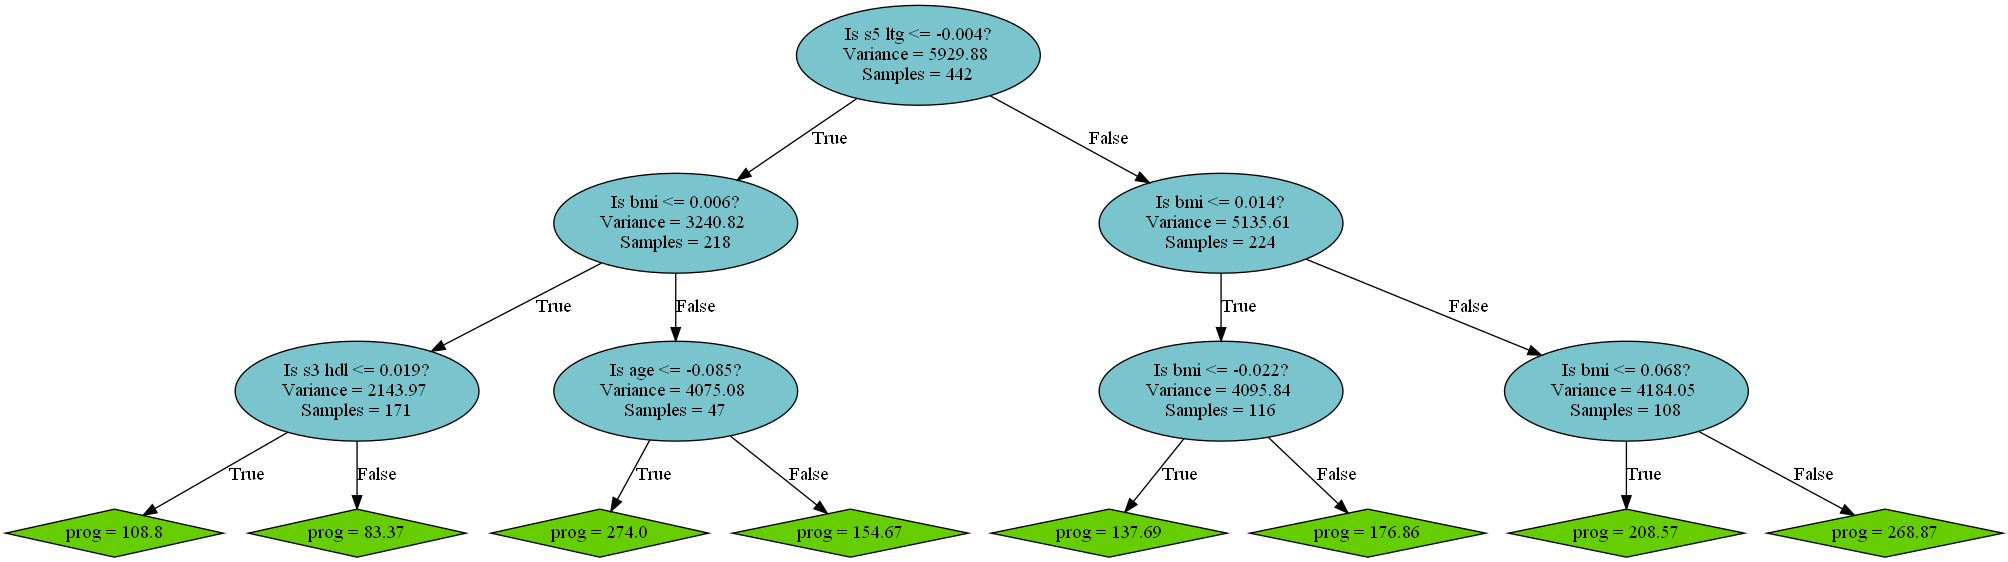

In [12]:
tree_graph = tree_to_dot(cart_tree)

tree_graph.write_png("../snapshots/cart_tree_regression.png")

# Display image directly without saving (requires IPython)
plt = Image(tree_graph.create_png())
display(plt)